In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from mpl_toolkits.basemap import Basemap
plt.rcParams["figure.figsize"] = (25,12)
from collections import Counter
from operator import itemgetter

# Data Processing

## Routes Dataset

<Big> <u>Flights Data</u></Big>

As of June 2014, the OpenFlights/Airline Route Mapper Route Database contains 67663 routes between 3321 airports on 548 airlines spanning the globe, as shown in the map above. Each entry contains the following information:
- **Airline**	2-letter (IATA) or 3-letter (ICAO) code of the airline.
- **Airline ID**	Unique OpenFlights identifier for airline (see Airline).
- **Source airport**	3-letter (IATA) or 4-letter (ICAO) code of the source airport.
- **Source airport ID**	Unique OpenFlights identifier for source airport (see Airport)
- **Destination airport**	3-letter (IATA) or 4-letter (ICAO) code of the destination airport.
- **Destination airport ID**	Unique OpenFlights identifier for destination airport (see Airport)
- **Codeshare**	"Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.
- **Stops**	Number of stops on this flight ("0" for direct)
- **Equipment**	3-letter codes for plane type(s) generally used on this flight, separated by spaces<br>
The data is UTF-8 encoded. The special value \N is used for "NULL" to indicate that no value is available, and is understood automatically by MySQL if imported.<br>
**Notes**:
- Routes are directional: if an airline operates services from A to B and from B to A, both A-B and B-A are listed separately.
- Routes where one carrier operates both its own and codeshare flights are listed only once.

We start by reading the csv and removing unnecessary columns (Airline, AirlineID, Source Airport ID, Destination Airport ID, Codeshare, Stops, Equipment). After that we renamed the columns of interest to 'origin' and 'destination'.

In [105]:
routes = pd.read_csv('routes.csv', sep=',', header=None)
routes = routes.drop([0,1,3,5,6,7,8], axis=1)

In [106]:
routes.rename(columns={2:'origin', 4:'destination'}, inplace=True)
routes

,origin,destination
0,AER,KZN
1,ASF,KZN
2,ASF,MRV
3,CEK,KZN
4,CEK,OVB
...,...,...
67658,WYA,ADL
67659,DME,FRU
67660,FRU,DME
67661,FRU,OSS


Removing isolated nodes

In [107]:
isolated = ['BMY', 'GEA', 'ILP', 'KNQ', 'KOC', 'LIF', 'MEE', 'TGJ', 'TOU', 'UVE','ERS', 'MPA', 'NDU', 'OND','BFI', 'CLM', 'ESD', 'FRD','AKB', 'DUT', 'IKO', 'KQA','SPB', 'SSB','CKX', 'TKJ','BLD', 'GCW', 'ACU',
'AWD', 'FTA', 'AXR', 'KKR', 'RFP', 'MAU', 'XMH', 'RGI', 'BOB', 'TIH', 'MVT', 'HUH', 'FAV', 'MOZ', 'MKP', 'HOI', 'GMR', 'NHV', 'UAP', 'UAH', 'TUB', 'RUR', 'TKP', 'TKX']

In [108]:
routes = routes[np.logical_not(routes.origin.isin(isolated))]
routes = routes[np.logical_not(routes.destination.isin(isolated))]

## Global Airport Database

The website from which we retrieved the flights dataset also had an airport database with IATA codes, however this database contained a lot of NA's so we found another database from [here](https://www.partow.net/miscellaneous/airportdatabase/)

|Name|Type|
|----|----|
|ICAO|Code|String (3-4 chars, A - Z)
|IATA|Code|String (3 chars, A - Z)
|Airport Name|String
|City/Town|	String
|Country|String
|Latitude Degrees|Integer [0,360]
|Latitude Minutes|Integer [0,60]
|Latitude Seconds|Integer [0,60]
|Latitude Direction|Char (N or S)
|Longitude Degrees|Integer [0,360]
|Longitude Minutes|Integer [0,60]
|Longitude Seconds|Integer [0,60]
|Longitude Direction|Char (E or W)
|Altitude|Integer [-99999,+99999] (Altitude in meters from mean sea level)
|Latitude Decimal Degrees|Floating point [-90,90]
|Longitude Decimal Degrees|Floating point [-180,180]

In [109]:
airports = pd.read_csv('GlobalAirportDatabase/GlobalAirportDatabase.txt', delimiter=':', header=None)
airports = airports.drop([0,2,5,6,7,8,9,10,11,12,13], axis=1)

In [110]:
airports = airports.rename({1:'iata', 3:'city', 4:'country', 14:'lat', 15:'long'}, axis=1)

In [111]:
# Remove IATA null values
airports = airports[~airports['iata'].isna()]
airports = airports.reset_index()
airports

,index,iata,city,country,lat,long
0,0,GKA,GOROKA,PAPUA NEW GUINEA,-6.082,145.392
1,1,LAE,LAE,PAPUA NEW GUINEA,0.000,0.000
2,2,MAG,MADANG,PAPUA NEW GUINEA,-5.207,145.789
3,3,HGU,MOUNT HAGEN,PAPUA NEW GUINEA,-5.826,144.296
4,4,LAE,NADZAB,PAPUA NEW GUINEA,-6.570,146.726
...,...,...,...,...,...,...
3557,9276,HTN,HOTAN,CHINA,37.038,79.866
3558,9278,URC,URUMQI,CHINA,43.907,87.474
3559,9286,HRB,HARBIN,CHINA,45.623,126.250
3560,9293,CGQ,CHANGCHUN,CHINA,0.000,0.000


Removing duplicate London Airport with wrong coordinates. Changing the country to correct form.

In [112]:
airports = airports.drop(index=460)
airports.at[478, 'country'] = 'ENGLAND'
airports.at[478, 'country']

'ENGLAND'

Changing 'ACORES' to 'PORTUGAL' in country

In [133]:
airports.loc[airports['country'] == 'ACORES', 'country'] = 'PORTUGAL'

## Routes dataset with only the values present in airports database

In [114]:
# routes[routes['origin'].isin(airports[1])]
routes = routes[(routes['origin'].isin(airports['iata'])) & routes['destination'].isin(airports['iata'])]
routes

,origin,destination
0,AER,KZN
1,ASF,KZN
2,ASF,MRV
3,CEK,KZN
4,CEK,OVB
...,...,...
67652,TSV,ISA
67654,WGA,MEL
67655,WGA,SYD
67661,FRU,OSS


## Group by [origin-destination]

In [115]:
origin_unique = np.unique(routes.origin)
dest_unique = np.unique(routes.destination)
nodes = np.unique(np.concatenate([origin_unique, dest_unique], axis=0))
# nodes
len(nodes)

2083

In [116]:
routes_weight = routes.groupby(['origin', 'destination']).size()
routes_weight

origin  destination
AAE     ALG            1
        CDG            1
        IST            1
        LYS            1
        MRS            2
                      ..
ZTH     VIE            2
ZVK     BKK            1
        PKZ            1
        VTE            1
ZYL     DAC            4
Length: 28686, dtype: int64

In [117]:
links = routes_weight.index.unique()
weights = routes_weight.tolist()
weight_input = [link + (weigth,)  for link, weigth in zip(links, weights)]
weight_input

[('AAE', 'ALG', 1),
 ('AAE', 'CDG', 1),
 ('AAE', 'IST', 1),
 ('AAE', 'LYS', 1),
 ('AAE', 'MRS', 2),
 ('AAE', 'ORN', 1),
 ('AAE', 'ORY', 2),
 ('AAL', 'AAR', 1),
 ('AAL', 'AGP', 1),
 ('AAL', 'ALC', 1),
 ('AAL', 'AMS', 2),
 ('AAL', 'ARN', 1),
 ('AAL', 'BCN', 2),
 ('AAL', 'BLL', 3),
 ('AAL', 'CPH', 2),
 ('AAL', 'IST', 1),
 ('AAL', 'LGW', 1),
 ('AAL', 'OSL', 3),
 ('AAL', 'PMI', 1),
 ('AAL', 'SVG', 1),
 ('AAR', 'AAL', 1),
 ('AAR', 'AGP', 1),
 ('AAR', 'BMA', 1),
 ('AAR', 'CPH', 1),
 ('AAR', 'GOT', 1),
 ('AAR', 'OSL', 1),
 ('AAR', 'PMI', 1),
 ('AAR', 'STN', 1),
 ('AAY', 'SAH', 1),
 ('ABA', 'IKT', 1),
 ('ABA', 'SVO', 1),
 ('ABD', 'SYZ', 1),
 ('ABD', 'THR', 3),
 ('ABI', 'DFW', 2),
 ('ABJ', 'ACC', 7),
 ('ABJ', 'ALG', 1),
 ('ABJ', 'BKO', 2),
 ('ABJ', 'BOY', 1),
 ('ABJ', 'BRU', 4),
 ('ABJ', 'CDG', 2),
 ('ABJ', 'CKY', 2),
 ('ABJ', 'CMN', 1),
 ('ABJ', 'COO', 3),
 ('ABJ', 'DKR', 3),
 ('ABJ', 'DLA', 1),
 ('ABJ', 'FNA', 1),
 ('ABJ', 'IST', 1),
 ('ABJ', 'LBV', 1),
 ('ABJ', 'LFW', 5),
 ('ABJ', 'LOS', 4),


## Graph Creation

In [118]:
graph = nx.Graph()

In [119]:
graph.add_nodes_from(nodes, bipartite=1)
graph.add_weighted_edges_from(weight_input)

In [120]:
nx.is_connected(graph)

True

## Plot

In [121]:
# plt.figure(figsize=(50,25))
m = Basemap(projection='cyl',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180,
            resolution='h', suppress_ticks=True)

In [122]:
mx, my = m(airports.long.values, airports.lat.values)
pos = {}
for count, elem in enumerate(airports['iata']):
    pos[elem] = (mx[count], my[count])


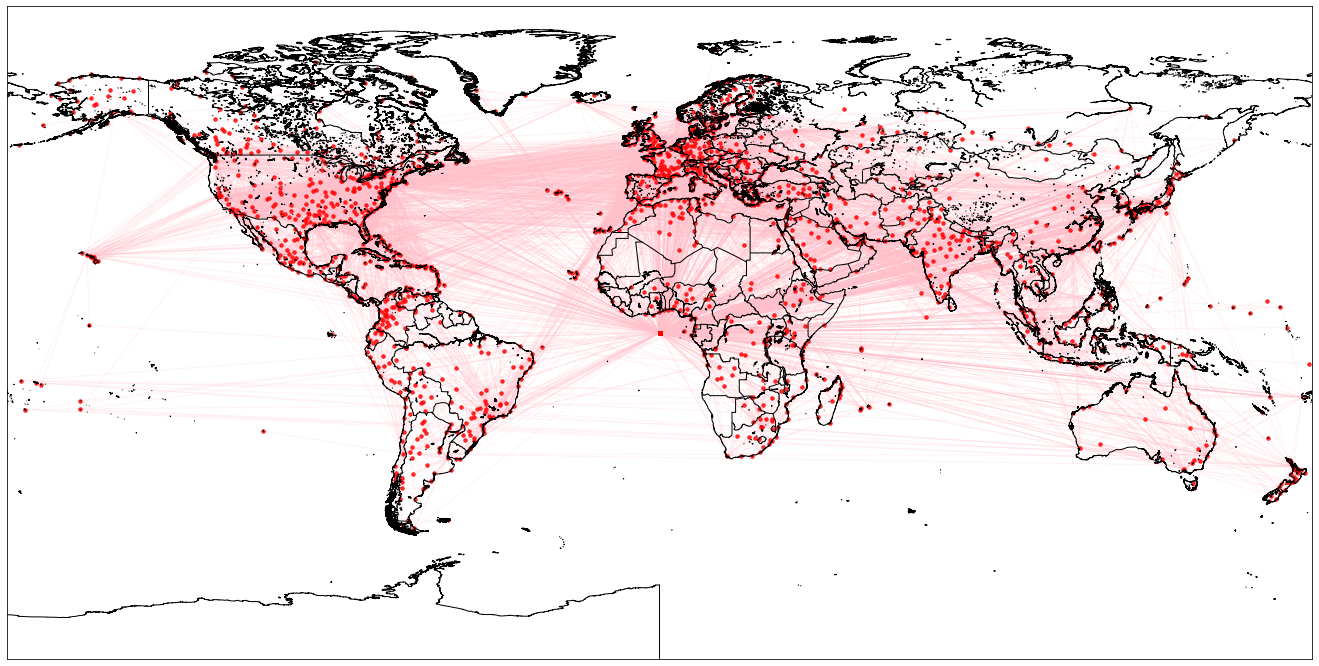

In [123]:
nx.draw_networkx_nodes(G=graph, pos=pos, nodelist=graph.nodes(), node_color='red', alpha=0.8, node_size=12)
nx.draw_networkx_edges(G=graph, pos=pos, edge_color='pink', alpha=0.2)
m.drawcountries(linewidth=1)
m.drawcoastlines(linewidth=1)
# plt.tight_layout()
plt.show()

## Plots

### Average Degree

In [124]:
print(nx.info(graph))
print(f"Average degree of the network: {2*len(graph.edges())/len(graph.nodes())}")

Graph with 2083 nodes and 14625 edges
Average degree of the network: 14.042246759481516


### Degree Distribution

Text(0, 0.5, 'Frequency')

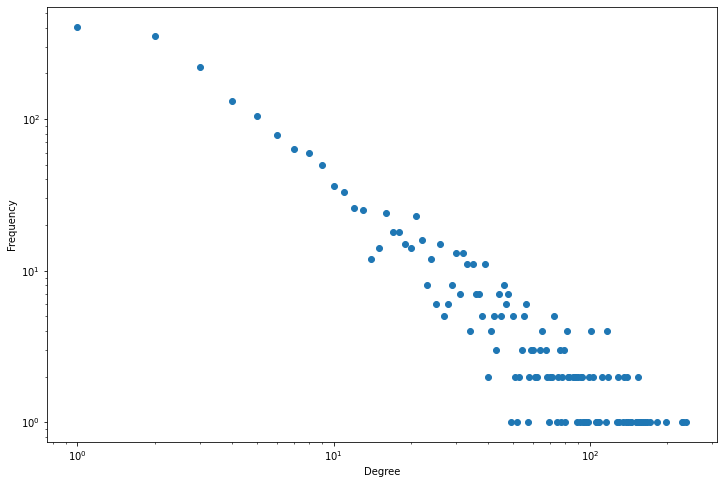

In [125]:
degree_freq = nx.degree_histogram(graph)
degrees = range(len(degree_freq))
plt.figure(figsize=(12,8))
plt.loglog(degrees, degree_freq, 'o')
plt.xlabel('Degree')
plt.ylabel('Frequency')

### Average Weighted Degree
i.e. the average number of different flights offeredfrom any airport,
$$<k^{w}> = \sum_{i-1}^{N} k_{i}^{w}/N$$

In [126]:
# weight_input[0][0]
weight_sum = 0
for entry in weight_input:
    weight_sum += entry[2]

print(f"The sum of the weights is: {weight_sum} and the total no. of airports is: {len(graph.nodes())}")
print(f"The Average Weighted Degree is: {weight_sum/len(graph.nodes())}") 

The sum of the weights is: 53967 and the total no. of airports is: 2083
The Average Weighted Degree is: 25.908305328852617


### Airport with the most connections

In [127]:
connections = {}
for airport in nodes:
    count = 0
    for entry in weight_input:
        # if(airport == entry[0] or airport == entry[1]):
        if (airport == entry[0]):
            count += entry[2]
        connections[airport] = count
# print(connections)

In [128]:
# {k: v for k, v in sorted(x.items(), key=lambda item: item[1])}
{k: v for k, v in sorted(connections.items(), key=lambda item: item[1], reverse=True)}

{'ATL': 773,
 'LHR': 508,
 'CDG': 504,
 'FRA': 465,
 'ORD': 462,
 'LAX': 445,
 'JFK': 442,
 'AMS': 434,
 'DFW': 413,
 'PEK': 395,
 'SIN': 374,
 'BCN': 373,
 'MIA': 361,
 'MUC': 346,
 'LGW': 336,
 'DXB': 323,
 'MAD': 321,
 'FCO': 310,
 'YYZ': 309,
 'HKG': 306,
 'BRU': 299,
 'IST': 298,
 'DEN': 295,
 'MAN': 295,
 'VIE': 289,
 'BKK': 269,
 'DUS': 267,
 'NRT': 259,
 'PHL': 254,
 'PMI': 253,
 'CLT': 251,
 'DEL': 245,
 'CAN': 244,
 'EWR': 244,
 'MEX': 240,
 'ZRH': 237,
 'CTU': 235,
 'PHX': 235,
 'KUL': 234,
 'IAH': 231,
 'AUH': 228,
 'MCO': 227,
 'SFO': 224,
 'CPH': 222,
 'BOM': 218,
 'LAS': 217,
 'TPE': 217,
 'LIS': 211,
 'ARN': 207,
 'BOS': 201,
 'HGH': 200,
 'XIY': 199,
 'AGP': 198,
 'CKG': 198,
 'DUB': 198,
 'TXL': 198,
 'KMG': 193,
 'ORY': 190,
 'GRU': 186,
 'MSP': 184,
 'XMN': 183,
 'FLL': 181,
 'SEA': 180,
 'MXP': 179,
 'DTW': 178,
 'YUL': 178,
 'IAD': 177,
 'SVO': 177,
 'OSL': 174,
 'DCA': 173,
 'SYD': 173,
 'CGK': 172,
 'JED': 170,
 'PRG': 170,
 'SZX': 167,
 'DOH': 166,
 'GVA': 162,

In [135]:
airports[airports['iata'].isin(['ATL','LHR','CDG','FRA','ORD','LAX','JFK','AMS','DFW','PEK'])]

,index,iata,city,country,lat,long
368,654,FRA,FRANKFURT,GERMANY,50.026,8.543
478,1164,LHR,LONDON,ENGLAND,51.477,-0.461
528,1330,AMS,AMSTERDAM,NETHERLANDS,52.309,4.764
1271,3401,ATL,ATLANTA,USA,33.640,-84.427
1337,3476,DFW,DALLAS-FORT WORTH,USA,32.896,-97.037
1451,3596,JFK,NEW YORK,USA,40.640,-73.779
1454,3601,LAX,LOS ANGELES,USA,33.942,-118.408
1557,3716,ORD,CHICAGO,USA,41.979,-87.904
1791,4283,CDG,PARIS,FRANCE,49.013,2.550
3496,9077,PEK,BEIJING,CHINA,40.080,116.584


### Average Path Length

In [136]:
print(nx.average_shortest_path_length(graph))

3.634257561901547


### Community Detection
**Fast unfolding of communities in large networks**

In [138]:
from networkx.algorithms.community.centrality import girvan_newman
communities = girvan_newman(graph)
node_groups = []
for com in next(communities):
  node_groups.append(list(com))

print(node_groups)


[['TZX', 'BOO', 'OAX', 'YOW', 'IXR', 'IPL', 'MOF', 'VDZ', 'CWB', 'SOJ', 'YBR', 'FYU', 'VNX', 'CRD', 'YKF', 'ERC', 'POZ', 'SDN', 'TYS', 'RIX', 'YQQ', 'RJK', 'HMO', 'SIT', 'TRU', 'HLH', 'KHS', 'BJF', 'PPP', 'BBN', 'GHA', 'HNA', 'BKY', 'KSA', 'CFU', 'AHB', 'UCT', 'YXS', 'BLV', 'EGN', 'LNE', 'VDM', 'LZC', 'RLG', 'CZL', 'NOP', 'NAN', 'CFE', 'NRK', 'BVE', 'JOG', 'PVK', 'RNO', 'JBR', 'ISA', 'OKA', 'NVK', 'XMN', 'HYD', 'TAK', 'NVT', 'HIR', 'RAR', 'COR', 'BTK', 'LPA', 'MKK', 'YPR', 'MKQ', 'PSR', 'YKS', 'ERF', 'SGY', 'LSP', 'PLX', 'ZCL', 'YTS', 'LAE', 'TBU', 'PUS', 'HUN', 'KNX', 'JYV', 'RHO', 'WIC', 'CSX', 'UAS', 'FJR', 'TIM', 'BOJ', 'HAD', 'IPH', 'BGI', 'OUD', 'JGA', 'BDS', 'BBO', 'CAJ', 'TRE', 'LUK', 'WMN', 'JUJ', 'GRU', 'BDO', 'KUO', 'NPE', 'CXJ', 'KSC', 'MJZ', 'PNS', 'HAK', 'MCN', 'AFL', 'VAS', 'KRP', 'AKY', 'SMA', 'LNK', 'YGX', 'SXF', 'TUF', 'PEM', 'TSA', 'YQR', 'YWK', 'XFW', 'BBI', 'TLC', 'SRP', 'TXK', 'MAJ', 'MOD', 'CZS', 'PHX', 'ACE', 'OCC', 'HNL', 'YVQ', 'ABQ', 'TUR', 'NGS', 'ZAL', 'ABS